# 22-6. 프로젝트 : 폐렴 진단기 성능개선

    * 22-1~5 예제를 바탕으로 성능 개선

# 22. 폐렴아 기다려라

    * X-RAY 이미지를 기반으로 하는 폐렴 진단 딥러닝 모델을 제작

## 22-4. 폐렴을 진단해보자.(1)

    * 캐글의 Chest X-Ray Images 데이터 셋 이용
    https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
    
    
    * 폐렴 구별법
        * X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰

 * Set-up

가장 먼저, 패키지(라이브러리)들을 import

In [26]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

    * 앞으로 필요한 변수들을 생성

In [27]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel0042/aiffel


    * 데이터 가져오기

In [28]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


    * train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [29]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


    * train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 볼 것

In [30]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1074
Pneumonia images count in training set: 3111


    * tf.data 인스턴스를 만들어 봅시다. 
    * tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해주는 역할


In [31]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

    * Train 데이터 셋, validation 데이터 셋 갯수 확인

In [32]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


    * 라벨 이름 확인

In [33]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


    * 라벨 데이터를 만들어 주는 함수 정의

In [34]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

- 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
- 이미지의 사이즈를 통일 시키고
- GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
- decode_img 함수와 process_path 함수를 만들겠습니다.

- process_path 함수에서 
- decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 
- 사이즈를 변경합니다. 
- get_label을 이용해서 라벨 값을 가져옵니다.

In [35]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

    * train 데이터 셋과 validation 데이터 셋을 만들기
    * num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해줌

In [36]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

    * 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인

In [38]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


    *  참고로, 코드에서 train_ds.take(1)은 하나의 데이터만 가져온다 라는 의미
    
    * 위에서 train과 validation 데이터 셋을 만든 것 처럼 test 데이터 셋도 만들기 
    * 그리고 데이터 갯수도 확인

In [39]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


    * prefetch()를 사용하면 학습데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

 ### 3. 데이터 시각화
 
     - 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다.
     - 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 
     - 이제 show_batch()함수를 이용해서 결과 사진을 보겠습니다.

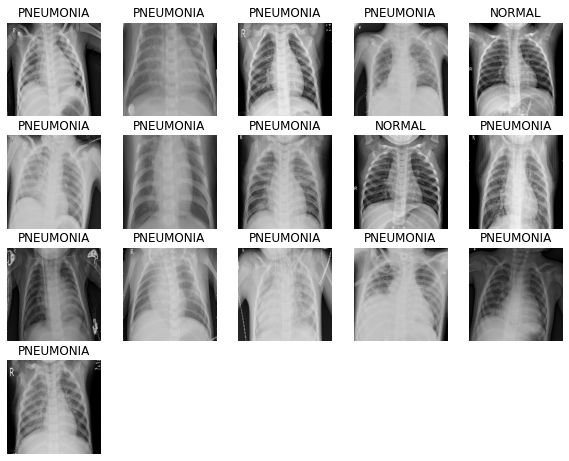

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## 22-5. 폐렴을 진단해보자(2)

### 4. CNN 모델링

    - 먼저, Convolution block을 만듭니다. 
    - conv_block()의 구성은 Convolution을 두번 진행하고 
    - Batch Normalization을 통해서 Gradient vanishing, 
      Gradient Exploding을 해결합니다. 
    - 그리고 Max Pooling을 합니다.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 5. 데이터 imbalance 처리

    - 한 라벨이 너무 많은 경우를 imbalance 하다고 함
    - imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있음
    
    - 이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용
    -  Weight balancing 은 training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
    - Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있음

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.97
Weight for class 1: 0.67


### 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 23s 88ms/step - loss: 0.3947 - accuracy: 0.8060 - precision: 0.9504 - recall: 0.7807 - val_loss: 0.9405 - val_accuracy: 0.7269 - val_precision: 0.7269 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 20s 77ms/step - loss: 0.2383 - accuracy: 0.9071 - precision: 0.9723 - recall: 0.9011 - val_loss: 1.4171 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 20s 75ms/step - loss: 0.2203 - accuracy: 0.9162 - precision: 0.9740 - recall: 0.9121 - val_loss: 0.1418 - val_accuracy: 0.9471 - val_precision: 0.9386 - val_recall: 0.9921
Epoch 4/25
261/261 [==============================] - 20s 75ms/step - loss: 0.1695 - accuracy: 0.9389 - precision: 0.9815 - recall: 0.9357 - val_loss: 0.4043 - val_accuracy: 0.8577 - val_precision: 0.9984 - val_recall: 0.8053
Epoch 5/25
261/261 [==============================] - 20s 76ms/step - loss: 0.1734 - accuracy: 0

### 7. 결과 확인

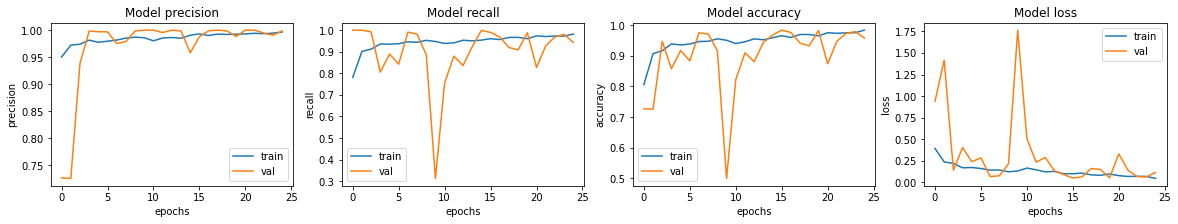

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 53ms/step - loss: 0.7662 - accuracy: 0.8734 - precision: 0.8463 - recall: 0.9744


# 22-6. 프로젝트 : 폐렴 진단기 성능개선


 * 루브릭
     1. 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인
     2. regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행
     3. Accuracy 기준 85%에 도달

## Step 1. 실험환경 Set-up

    * Batch size, Epoch 등을 변경

## Step 2. 데이터 준비하기

    * 이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것
    * 그러나 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없음
    * 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문
    
    * 좌우반전 정도의 augmentation만 도입

In [42]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

    * 학습용 데이터를 시각화해서 확인
    * 만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인

In [43]:
label_batch

<tf.Tensor: shape=(), dtype=bool, numpy=True>

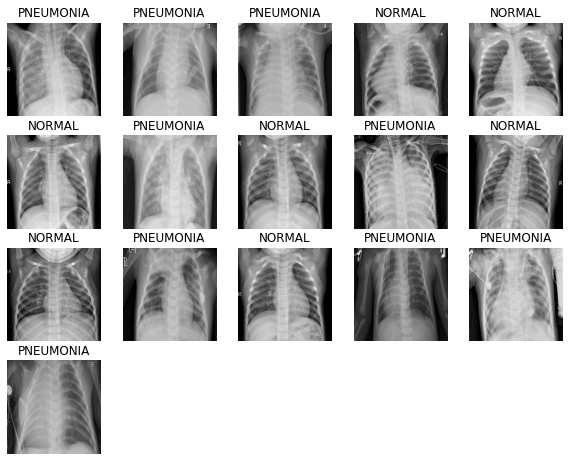

In [44]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

    * Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있음
    * BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있음

In [45]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

    * Dropout 삭제

In [46]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [47]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

 ## Step 5. 데이터 imbalance 처리
 
     * 실습코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 
     * 만약 이러한 처리를 생략한다면 어떻게 될까요? 
     * 또 recall을 강조하기 위해 폐렴데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요? 

* class_weight 생략

In [48]:
# weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
# weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

# class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

 ## Step 6. 모델 훈련
     
     * loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것

In [49]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [50]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 20s 77ms/step - loss: 0.2549 - accuracy: 0.9049 - precision: 0.9574 - recall: 0.9127 - val_loss: 0.8213 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 20s 77ms/step - loss: 0.1502 - accuracy: 0.9452 - precision: 0.9645 - recall: 0.9617 - val_loss: 1.4391 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 20s 75ms/step - loss: 0.1285 - accuracy: 0.9569 - precision: 0.9719 - recall: 0.9700 - val_loss: 0.1450 - val_accuracy: 0.9442 - val_precision: 0.9363 - val_recall: 0.9922
Epoch 4/25
261/261 [==============================] - 20s 75ms/step - loss: 0.1203 - accuracy: 0.9579 - precision: 0.9704 - recall: 0.9729 - val_loss: 0.2653 - val_accuracy: 0.8990 - val_precision: 1.0000 - val_recall: 0.8629
Epoch 5/25
261/261 [==============================] - 19s 74ms/step - loss: 0.0975 - accuracy: 0

 ## Step 7. 결과 확인과 시각화

    * 테스트데이터로 훈련된 모델을 평가
    * 우선은 accuracy를 고려해야겠지만 
    * 의료영상 모델의 특성상 recall도 중요합니다. 
    * 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석

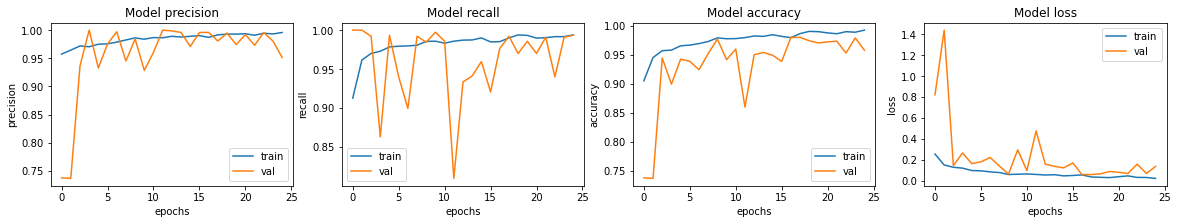

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [52]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 53ms/step - loss: 2.5524 - accuracy: 0.7035 - precision: 0.6783 - recall: 1.0000
